<a href="https://colab.research.google.com/github/claudia-viaro/optimal_stopping-switching/blob/main/optimal_switching/opt_switching_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Suppose we fix the final regime of the process

#Problem Formulation
Let $(\Omega, \mathcal{F}, P)$ be a fixed probability space on which an adapted stochastic process is defined $X=(X_t)_{0 \leq t \leq T}$ whose natural filtration is $(\mathcal{F}_t^0 := \sigma \{ X_s, s \leq t \})_{0 \leq t \leq T}$. Let $\mathbf{F}=(\mathcal{F}_0)_{0 \leq t \leq t}$ be the complete filtration of $(\mathcal{F}_t^0 := \sigma \{ X_s, s \leq t \})_{0 \leq t \leq T}$. with $P$-null sets of $\mathcal{F}$.

The stochastic process $X$ is $\mathbb{R}^d$-valued and represents the market price of $d$ financial assets (Bermudan call options) that influence the production of power. Assume $(X^i)_{i=1}^d$ follows a geometric Brownian motion satisfying the SDE:
\begin{equation}
dX_t = b_{I_t}X_tdt + \sigma_{I_t}X_tdW_t
\end{equation}
where $W$ is a standard Brownian motion on a filtered probability space $(\Omega, \mathcal{F}, \mathbf{F}=(\mathcal{F}_t)_{t \geq 0} P)$ and $I_t$ is the indicator variable of the regimes valued in $\mathbf{I}_d = \{1, \ldots, d \}$. $b_i \in \mathbf{R}$ and $\sigma_i >0$ are the drift and volatility of the system $X$ once in regime $I_t=i$ at time $t$.

We will consider a discrete approximization (Euler schema) with respect to. For $i = 1, \ldots, d$ we simulate $p$ paths
\begin{equation}
X^p_{n,i} = \exp \Big\{ \sum_{k=0}^n \big( (b-\sigma^2_i /2)_{\mathbf{I}}\Delta t + \sigma_{i, \mathbf{I}} \sqrt{\Delta t} \cdot Z_{k, i}^p \big)     \Big\}
\end{equation}
where $\Delta t = T/N$ and $Z_{k, i}^{p} \sim \mathcal{N} (0,1)$.



In [20]:
import numpy as np
import torch
import torch.nn as nn
np.random.seed(234198)
import itertools
import random
import time
import scipy.stats

import math
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.utils.data as tdata

In [21]:
class BlackScholes:
  def __init__(self, drift, sigma, delta, spot, assets,  paths, periods,
         maturity, strike, dividend=0):

    self.drift = drift - dividend
    self.sigma = sigma
    self.delta = delta
    self.spot = spot
    self.assets = assets
    self.paths = paths
    self.periods = periods
    self.maturity = maturity
    self.strike = strike
    self.dt = self.maturity / self.periods
    self.df = math.exp(-self.drift * self.dt)

  def drift_fct(self, x, t):
    del t
    return self.drift * x

  def diffusion_fct(self, x, t, v=0):
    del t
    return self.sigma * x



  def simulate_process(self):
    """Returns a nparray (nb_paths * assets * nb_dates) with prices."""
    paths = self.paths
    spot_paths = np.empty((self.periods+1, paths, self.assets ))

    spot_paths[0, :, :] = self.spot
    random_numbers = np.random.normal(0, 1, (self.periods, paths, self.assets ))
    dW = random_numbers * np.sqrt(self.dt)
    drift = self.drift
    r = np.repeat(np.repeat(np.repeat(
        np.reshape(drift, (-1, 1, 1)), self.periods, axis=0),
        paths, axis=1), self.assets, axis=2)
    sig = np.ones((self.periods, paths, self.assets))*self.sigma
    
    spot_paths[1:, :,  :] = np.repeat(
        spot_paths[0:1, :, :], self.periods, axis=0)* np.exp(np.cumsum((r-self.delta) * self.dt - (sig ** 2) * self.dt / 2 + sig * dW, axis=0))

    return spot_paths #.reshape(spot_paths.shape[2], spot_paths.shape[0], spot_paths.shape[1])


'''
PLOT
'''

def draw_stock_model(stockmodel):
    stock_paths = stockmodel

    # draw a path
    one_path = stock_paths[:, 0, 0]
    dates = np.array([i for i in range(len(one_path))])
    plt.plot(dates, one_path, label='stock path')
    plt.ylabel('Stock price')
    plt.ylabel('Time')
    plt.legend()
    return plt.show()

We employ a neural network to approximate the stopping decision functions $\{f_n\}_{n=0}^N$ by constructing a sequence of neural networks of the form $f^{\theta_n}:\mathbb{R}^d → \{0,1\}$ with parameters $\theta_n \in \mathbb{R}^q$ to approximate $f_n$.


In its basic form, a neural network is composed of several layers, and layers are made of nodes. From the picture below, we can observe that a node combines input from the data, $x_{1:n}$, with a set of weights, $w_{1:n}$, that either amplify or dampen that input, thereby assigning significance to inputs with regard to the task the algorithm is trying to learn. $x_{1:n}$ are either the inputs of the overall network if this node is in the first layer or the outputs from the previous layer. Then, the input-weight products are summed, usually with a bias term, and the sum is passed through a node’s so-called activation function $f$, to determine whether and to what extent that signal should progress further through the network to affect the ultimate outcome (depending on the magnitude of each associated weight $w_i$). If the signals passes through, we can say that the neuron has been “activated” and returns an output.


![](https://drive.google.com/uc?export=view&id=1rButBJka1QjKsLSrAWgJKrxNCGdntf-K)

Generally, NNs comprise multiple node layers through which data is passed, giving rise to what can be referred to as the depth of a neural network. In such networks, each layer of nodes trains on a distinct set of features based on the previous layer’s output. The further we move into the neural net, the more complex the features can be recognized by the nodes, since they aggregate and recombine features from the previous layer.

![](https://drive.google.com/uc?export=view&id=1b8Hbzn5xahE9jHf5jgIslG3dedkLAHst)

The neural network used here takes the form $F^{\theta}: \mathbb{R}^d → (0,1)$ for $\theta \in \{\theta_0, \ldots, \theta_N  \}$, that is the parameters are trained via a neural network that outputs probabilities in the interval $(0,1)$. This is due to the fact that the G-B optimization algorithm is to be applied to a continuous function with respect to $\theta_n$, which $f^{\theta_n}$ is not. Hence, the multi-layer, feed-forward neural network takes the form:

\begin{equation}
F^{\theta}= \psi \circ a_3^{\theta} \circ \phi_{q_2} \circ a_2^{\theta} \circ \phi_{q_1} \circ a_1^{\theta}
\end{equation}
where 

-  $q_1, q_2$ are the number of nodes in the hidden layers
- $a_1^{\theta} : \mathbb{R}^d → \mathbb{R}^{q_1}, a_2^{\theta}: \mathbb{R}^{q_1} → \mathbb{R}^{q_2}$ are linear transformation functions: $a_i^{\theta}(x)=W_i x + b_i$ with matrices $W_1 \in \mathbb{R}^{q_1 \times d}, W_2 \in \mathbb{R}^{q_2 \times q_1}, W_3 \in \mathbb{R}^{q_2 \times 1}$ and vectors $b_1 \in \mathbb{R}^{q_1}, b_2 \in \mathbb{R}^{q_2}, b_3 \in \mathbb{R}^{1}$.
- $\phi_{q_i}: \mathbb{R}^{q_i}$ is the ReLU activation function: $\phi_{q_1}(x_i, \ldots, x_{q_i})=(x_i^{+}, \ldots, x_{q_i}^{+})$
- $\psi = \mathbb{R} → \mathbb{R}$ is the logistic sigmoid function: $\psi(x)=1/(1+ e^{-x})$.
Between the layers a batch normalization is also added, it takes the output from the previous layer and normalizes it before sending it to the next layer. This has the effect of stabilizing the neural network. 

The parameters will comprise $\theta = \{W_1, W_2,, W_3, b_1, b_2, b_3\}\in \mathbb{R}^q$, where $q=q_1(d+q_2+1)+2q_2+1$. The value of $d$ stands for the dimension, that is the number of assets and will be varied among $d=\{2,4, 5, 10, 20\}. 





In [22]:
''' NEURAL NETWORK'''

class Ftheta_NN(nn.Module):
  def __init__(self, assets):
    super(Ftheta_NN, self).__init__()
    H = assets + 40
    self.bn0 = nn.BatchNorm1d(num_features=assets)
    self.a1 = nn.Linear(assets, H)
    self.relu = nn.ReLU()
    self.bn1 = nn.BatchNorm1d(num_features=H)
    self.a2 = nn.Linear(H, H)
    self.bn2 = nn.BatchNorm1d(num_features=H)
    self.a3 = nn.Linear(H, 1)
    self.bn3 = nn.BatchNorm1d(num_features=1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, input):
    out = self.bn0(input)
    out = self.a1(out)

    out = self.relu(out)
    out = self.bn1(out)

    #out = self.a2(out)
    
    #out = self.relu(out)
    #out = self.bn2(out)
    out = self.a3(out)
    
    out = self.sigmoid(out)
    return out

# set initial weights of a linear layer of the NN with uniform values and bias=0.01 (or choose zero initial weights)
def init_weights(m):
  if isinstance(m, torch.nn.Linear):
    torch.manual_seed(42)
    #torch.nn.init.zeros_(m.weight)
    torch.nn.init.xavier_uniform_(m.weight)
    m.bias.data.fill_(0.01)

# Class "Training_network"

The NN is used to approximate the optimal stopping decisions $f_n: \mathbb{R}^d \rightarrow \{0, 1 \}$, $n = \{ 1, \ldots, N-1 \}$, at each date by a neural network $f^{\theta}: \mathbb{R}^d \rightarrow \{0, 1 \}$ with parameter $\theta \in \mathbb{R}^q$. 

We choose $\theta_N \in \mathbb{R}^q$ such that $f^{\theta}_N \equiv 1$ and determine $\theta_n \in \mathbb{R}^q$ for $n \leq N-1$ by recursion of the form:

\begin{equation}
\tau_{n+1} = \sum_{m=n+1}^N m f^{\theta_m}(X_m) \prod _{j=n+1}^{m-1} (1-f^{\theta_j}(X_j))
\end{equation}

Since $f^{\theta}$ takes values in $\{ 0,1 \}$, hence not appropriate for a gradient-descent optimization method, the neural network includes a layer performing a logistic transformation such that we have a continuous output function $F^{\theta}: \mathbb{R}^d \rightarrow (0,1)$.

At each time step, for each epoch we compute $F^{\theta_n}$ using the $\theta_n$ from the previous epoch. Then, the parameter $\theta_n$ is update via backpropagation by the gradient of the loss function (Adam optimization algorithm \citep{kingma2014adam}), which is specified as:

\begin{equation}
    Loss = - \mathbb{E}[g(n, X_n)F^{\theta_n}(X_n) + g(\tau_{n+1}, X_{\tau_{n+1}})(1-F^{\theta_n}(X_n))]
\end{equation}

The aim is to determine $\theta_n \in \mathbb{R}^q$ so that the negative of the loss function is close to the supremum $\sup_{\theta \in \mathbb{R}^q}\mathbb{E}[g(n, X_n)F^{\theta}(X_n) + g(\tau_{n+1}, X_{\tau_{n+1}})(1-F^{\theta}(X_n))   ]$. 

Looking at the formula for the loss function, it takes as inputs:
- _current payoff:_ payoff of the option computed at time $n$ for all paths if it is exercised at time $n$. this is the value of the option at time $n$ when it is exercised
- _future payoff:_ expected value of the future payoff, computed at a stopping time observed in the future ($\tau+1$), this is the value of the option at time $n$ when it is not exercised (continuation value)

The NN takes as inputs:
- _stock prices:_ the prices of the stock at time $n$ across multiple paths

and as outputs:
- values in $\{ 0,1 \}$, representing the probability of stopping the process (exercising the option). 

In [23]:
class Training_network(object):

  def __init__(self, assets, epochs = 400, batch_size=2000):
    self.assets = assets
    self.epochs = epochs
    self.batch_size = batch_size
    self.network = Ftheta_NN(self.assets).double()
    self.network.apply(init_weights) # move later (?), not sure where it makes more sense to init params


  def train_network(self,  stock_values, current_payoff,
                    future_payoff):

    #self.network.apply(init_weights) # not sure where it makes more sense to init params

    # set values for the loss
    # current_payoff, future_payoff are already tensors
    ones = torch.ones(len(future_payoff)) # we need a vector of 1's in the loss function

    # set values for the NN inputs (stock_values) 
    X_inputs = torch.from_numpy(stock_values).double() 


    # several optimization methods are available (here Adam algorithm). as argument input the parameters to be optimized    
    # try diff learning rates
    optimizer = optim.Adam(self.network.parameters())
    self.network.train(True) # set training mode ON    
    losses = []

    for epoch in range(self.epochs):
      running_loss = 0.0

      for batch in tdata.BatchSampler(
              tdata.RandomSampler(range(len(X_inputs)), replacement=False),
              batch_size=self.batch_size, drop_last=False):
        
        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
          outputs = self.network.forward(X_inputs[batch]).reshape(-1) 
          reward = (current_payoff[batch].reshape(-1) * outputs + future_payoff[batch] * (ones[batch] - outputs) )

          # compute loss function
          loss = -torch.mean(reward)

          # compute gradients and backpropagate
          loss.backward() 

          # take a step, updating the parameters  
          optimizer.step() 

          running_loss += loss.item() * self.batch_size
      epoch_loss = running_loss /  len(tdata.BatchSampler(
              tdata.RandomSampler(range(len(X_inputs)), replacement=False),
              batch_size=self.batch_size, drop_last=False).sampler)
      losses.append(epoch_loss*(-1))


    torch.save(self.network.state_dict(), 'checkpoint.pth')# (?)
    return outputs, self.network, losses, self.network.state_dict()  

  def evaluate_network(self, X_inputs, date):
    self.network.load_state_dict(torch.load(f"test{date}.pth"))
    self.network.eval()
    X_inputs = torch.from_numpy(X_inputs).double()
    outputs = self.network(X_inputs)

    
    return outputs.view(len(X_inputs)).detach().numpy()    

# Class "Payoff"
This class contains various payoff and costs elements that define the reward. The final profit value is computed for each date and path.

### terminal reward
The terminal function $\Gamma_T$ is set to an option payoff function of choice regardless of the regime in which the process is at, in this case we have a Max Call. (other choices can be made as well). The terminal payoff is received at maturity, with no other costs nor payoffs.
\begin{equation}
\Gamma(T) = \Big(\max_{d \in \{1, \ldots, D \}} x^d - K   \Big)^{+} \tag{1}
\end{equation}

### running reward
The function $\Psi_i = (\Psi_i(t))_{n \in \mathbb{N}}$ represents the running reward received while in mode $i \in \mathbb{I}$. 
\begin{equation}
\Psi_i(t) = \Big[\Big(\max_{d \in \{1, \ldots, D\}} x^d - K   \Big)^{+} \Big] \tag{2}
\end{equation}

### switching cost
The function $\gamma_{i, j} = (\gamma_{i, j}(t))_{t \in \mathbb{T}}$ with $i,j \in \mathbb{I} = \{0, 1 \}$ represents the cost for switching from mode $i \in \mathbb{I}$ to mode $j \in \mathbb{I}$.
\begin{equation} \tag{3}
\begin{aligned}
&\gamma_{0,0} \equiv \gamma_{1,1} \equiv 0 \\
&\gamma_{0,1}(t) = \Big(\Big(\max_{d \in \{1, \ldots, D \}} x^d - K   \Big)^{+}\Big)^{0.3} + \delta  \;\;\;\;\; \delta \sim \mathcal{N}(0,1)   \\ 
&\gamma_{1, 0}(t) = - \Big(\max_{d \in \{1, \ldots, D \}} x^d - K   \Big)^{+} 
\end{aligned}
\end{equation}

### the full expression for the profit
The entire expression for the value of the process at each time $n$, $g(t, X_t, i)$ can be decomposed in: 
- $g(T, X_T, i)$ the terminal payoff: 
  \begin{equation} \tag{4}
  \tilde{Y}_{T}^i = \Gamma \mathbf{1}_{\{\tau = T\}} 
  \end{equation}
- $g(t, X_t, i)$ the payoff at any date before maturity, distinguishing whether the process switched ($i \neq j$) or not ($i = j$):
  \begin{equation}
  \begin{aligned}
  \tilde{Y}_{t}^i &= - \gamma_{i, j}(\tau) + \Psi_i(\tau) + \mathbb{E}[\tilde{Y}_{t+1}^i | \mathcal{F}_t] \;\;\;\;\; \text{if } i \neq j \text{,   for    } t \leq T-1 \\
  &= \Psi_i(\tau) + \mathbb{E}[\tilde{Y}_{t+1}^i | \mathcal{F}_t]  \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\; \text{if } i = j \text{,   for    } t \leq T-1
  \end{aligned}
  \end{equation}


# The functions
There are two main functions:
1. _current value:_ it computes the value of the current payoff when there is a switch, considering both alternatives 0-1 and 1-0
2. _continuation value:_  it computes the value of the current payoff when there is not a switch, hence the discounted expected value of the process when switched at a future switching time

In [24]:
class Payoff:
  def __init__(self, model):
    self.strike = model.strike
    self.model = model 
  
  def terminal_(self, n, X): # already get tensor
    a = torch.tensor(())
    for m in range(0, self.model.paths):
      date = n[m]
      tensorX= torch.from_numpy(X[int(date),m,:])
      max1=torch.max(tensorX-100)  
      max2 = torch.max(max1, torch.tensor([0.0])).float() 
      a = torch.cat((a, max2), 0)
    return a

  def running(self, X):
    # X is X[int(date),m,:]
    tensorX= torch.from_numpy(X)
    max1=torch.max(tensorX-100) 
    max2 = torch.max(max1, torch.tensor([0.0])).float() 
    #i = torch.tensor([max1]).float()
    return max2 
  
  def continuation_payoff(self, data, Y, t):
    # t is tau plus one
    # data is stock_paths
    a = torch.tensor(())
    for m in range(0, self.model.paths):
      date1 = t[m]
      value = Y[int(date1), m] # no need of plus one as it is already like that
      running_benefit = self.running(data[int(date1), m, :])      
      i = torch.tensor([value + running_benefit]).float()
      a = torch.cat((a, i), 0)         
    return a
  
  def payoff_Nswitch(self, X, tau, Y, date):
    a = np.array([])
    for m in range(0, self.model.paths):
      date1 = tau[m]
      value = Y[int(date1), m] # no need of plus one as it is already like that
      runn1 = self.running(X[int(date1), m, :])      
      i = (value + runn1.numpy())*np.exp(-self.model.drift*self.model.dt*(date1-date))
      a = np.concatenate((a, i), 0)
    return a  

  def payoff_Yswitch(self, X, date, Y, regimepath, regimes):
    a = np.array([])
    for m in range(0, self.model.paths):
      old_regime = int(regimepath[date +1, m])
      regimepath[date, m] = regimes[~old_regime]
      current_regime = regimepath[date, m]
      Yvalue = Y[date+1, m]
      runn = (self.running(X[int(date), m, :])).numpy()
      if (old_regime - current_regime)>0:  
        gamma = self.running(X[date, m, :])**0.3+np.random.normal(0,1,1) #gamma 0-1
        i = gamma.numpy() + Yvalue + runn
        a = np.concatenate((a, i), 0)
      else: 
        gamma = - self.running(X[date, m, :])  #gamma 1-0  
        i = gamma.numpy() + Yvalue + runn
        a = np.concatenate((a, i), 0)
    return a   

  def current_payoff(self, data, Y, date, regimes, regimepath):
    a = torch.tensor(())     
    for m in range(0, self.model.paths):
        value = Y[date+1, m]
        running_benefit = self.running(data[date, m, :])    
        old_regime = int(regimepath[date +1, m])     
        current_regime = regimes[~old_regime]        
        if (old_regime - current_regime)>0:          #gamma 0-1
          gamma = self.running(data[date, m, :])**0.3 +np.random.normal(0,1,1)         
        else:
          gamma = - self.running(data[date, m, :]) #gamma 1-0          
        i = torch.tensor([value + running_benefit+gamma]).float()
        a = torch.cat((a, i), 0)            
    return a

# Class "Training"

This is a recursion. It starts by initializing:
- model, that is the simulated stock prices
- payoff class
- NN 

Create some matrices to store values that will be accessed to at different time steps
- _mods_ records the models at each time step, basically it appends, by date, the networks (not sure if it is enough to say that it stores the optimized parameters)
- _loss functions:_ just to plot
- _regime path:_ matrix $(n \times m)$, it records in which regime the process is at (for the same date, there are multiple paths which can be in different regimes)
- _Y train:_ vector $(n \times 1)$, it records the profit, as it is needed at each iteration
- _tau dates:_ matrix $(n \times m)$, it records for each date when there is a stopping time (can only be at such date or higher)
- _F theta:_ matrix $(n \times m)$, it records the outputs of the NN (0,1 values), only used to obtain the tau_dates

The backward induction goes as:
1. at maturity
  - compute the terminal payoff and record it in _Y train_
  - no need to compute the stopping times/stopping decision functions because by construction $f_N \equiv 1$. Hence, set F_theta[N,:]=1 and tau_dates[N,:]=N
  - sample a regime for the process at that time (same for all paths)

2. before maturity
- compute values for training the NN, hence current payoff $g(n, X_n, i)$ and future payoff $g(\tau_{n+1}, X_{\tau_{n+1}}, i)$. 

  To compute the payoff we need: stock values, date, one step ahead Y and the regime of the $n+1$ date because we need to identify which running cost function to use. It is a payoff when there is a switching so old regime and current regime are different.

  The future payoff needs as time variable $\tau_{n+1}$, we get it from the matrix tau-dates, taking value at $n+1$. The future payoff, as it refers to a value at time $\tau_{n+1}$, needs to be discounted to $n$.
- feed in the values in the function neural_stopping.train_network()
- using the outputs returned by this function, we record switching decisions in matrix _F theta_ and optimal switching time in matrix _tau dates_
- compute the "actual" current payoff. As we now know if there was or not a switch, we can compute the current payoff accordingly. we need to do this to record the value in _Y train_

This is repeated until $n=1$

In [25]:
class Training:
  def __init__(self, model, payoff_function):

    self.model = model    
    self.neural_stopping = Training_network(self.model.assets, 400) 
    self.payoff = payoff_function(self.model)

  def value(self):
    model = self.model
    stock_paths = self.model.simulate_process()   
    
    # create empty objects to store values
    regimes = [0, 1]
    regime_path=np.zeros((model.periods+1, model.paths)) # record at which regime we're at at each n
    Y_train=np.zeros((model.periods+1, model.paths))
    F_theta_train=np.zeros((model.periods+1,model.paths)) # record switching events for each n
    tau_dates=np.zeros((model.periods+1,model.paths)) # switching times
 
    mods=[None]*model.periods # record the models of the NN for testing
    loss_functions = [None]*model.periods
    parameters=[None]*model.periods

    # AT MATURITY
    tau_dates[model.periods,:]=model.periods # by def 
    final_dates =  tau_dates[model.periods,:]
    final_payoff = self.payoff.terminal_(final_dates, stock_paths) 

    # record values
    Y_train[model.periods, :]= final_payoff.numpy()
    F_theta_train[model.periods,:]=1 # by def
     
    regime_path[model.periods, :] = random.sample(regimes, 1)[0] # sample a regime at maturity
    print("date", model.periods, ", # switches", model.paths)

    # BEFORE MATURITY
    for date in range(stock_paths.shape[0] - 2, 0, -1): 
      tau_date_plus_one = tau_dates[date+1, :]
      discount_factor = np.exp(-model.drift*model.dt*(tau_date_plus_one-date))

      continuation_value =  self.payoff.continuation_payoff(stock_paths, Y_train, tau_date_plus_one)
      current_payoff = self.payoff.current_payoff(data = stock_paths, 
                                               Y = Y_train, date = date, 
                                               regimes = regimes,
                                               regimepath = regime_path)

      stopping_probability, networks, loss, params = self.neural_stopping.train_network(stock_paths[date, : , :], 
                                                    current_payoff, 
                                                    continuation_value*discount_factor)

      print("date", date, ", # switches", len([1 for l in stopping_probability if l > 0.5]), " mean reward ", np.mean(loss))
      
      # record values
      F_theta_train[date,:]=(stopping_probability > 0.5)*1.0   # transform stopping probabilities in 0-1 decision
      mods[date]=networks
      parameters[date]=params
      torch.save(params, f"test{date}.pth")
      loss_functions[date]=loss
      tau_dates[date,:]=np.argmax(F_theta_train, axis=0)

      which = stopping_probability > 0.5
      
      # compute the payoff taking into account if the regime switches (because the payoff funciton is different depending on that)    
      if_switch = self.payoff.payoff_Yswitch(stock_paths, date, Y_train, regime_path, regimes) 
      if_no_switch = self.payoff.payoff_Nswitch(stock_paths, tau_date_plus_one, Y_train, date) 

      current_payoff = current_payoff.numpy()
      # the final value is this "current_payoff", where we take for each path, either the expected future payoff or current
      current_payoff[which] = if_switch[which]       # when we switch we take the current profit and distinguish if 0-1, 1-0
      current_payoff[~which] = if_no_switch[~which]  # when we don't switch we take the discounted expected profit (when switched at a future stopping time)
      Y_train[date, :] = current_payoff # update Y_train    
    
    return mods, loss_functions

In [26]:
# simulate paths Y
# goal of this phase is to be able to get stopping decisions f_theta_n
hyperparam_training = {'drift': 0.2, 'sigma': 0.05, 'delta': 0.1,  'paths':1000, 'periods': 9, 'maturity': 1., 'strike' : 100,'assets':2,  'spot':90,}
S_train=BlackScholes(**hyperparam_training)

pricing = Training(S_train, Payoff)
'''
arguments are:
- path process
- Payoff class
'''

mods, functions = pricing.value()

date 9 , # switches 1000
date 8 , # switches 430  mean reward  11.693706742919998
date 7 , # switches 133  mean reward  12.58654580357918
date 6 , # switches 519  mean reward  14.14924246205424
date 5 , # switches 598  mean reward  13.916887892793847
date 4 , # switches 744  mean reward  13.954962317179257
date 3 , # switches 979  mean reward  13.866411970402178
date 2 , # switches 984  mean reward  13.971622022221228
date 1 , # switches 996  mean reward  13.772347401404339


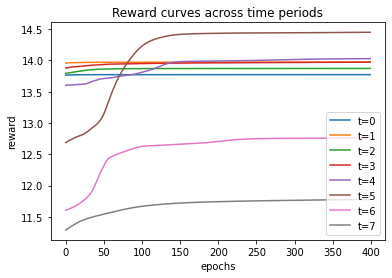

In [27]:
filtered_list = list(filter(None, functions))
legend = [f't={i}' for i in range(len(functions))]

for i in range(len(filtered_list)):
  epochs = np.array([i for i in range(len(filtered_list[0]))])
  plt.plot(epochs, filtered_list[i], label='reward function')
  plt.ylabel('reward')
  plt.xlabel('epochs')
  plt.legend(legend)
  plt.title('Reward curves across time periods')
  plt.plot()

#Lower bound

the stopping time $\tau^{\Theta}$ gives a lower bound $L=\mathbb{E}g(\tau^{\Theta}, X_{\tau^{\Theta}})$ for the optimal value $V_0= \sup_{\tau \in \mathcal{T}}\mathbb{E}g(\tau, X_{\tau})$.

Simulate 
- $K_L = 1024$ paths $(y_n^k)_{n=0}^N$, $k=1, \ldots, K_L$, of $(X_n)_{n=0}^N$ and assume these are drawn independently from the realizations $(x_n^k)_{n=0}^N$, $k=1, \ldots, K$.

The unbiased estimate of the lower bound $L$ is given by
\begin{equation}
\hat{L}=\frac{1}{K_L} \sum_{k=1}^{K_L} g(l^k, y_{l^k}^k)
\end{equation}
where $l^k = l(y_0^k, \ldots, y_{N-1}^k)$

In [34]:
# Testing

class Testing_Lower:
  def __init__(self, model, payoff_function, mods):   
    self.model = model # argument is S   
    self.neural_stopping = Training_network(model.assets, 400) 
    self.payoff = payoff_function(self.model)
    #self.mods = mods

  def value(self):
    model = self.model
    #disc_factor = np.math.exp((-model.drift) * model.maturity/(model.periods))
    stock_paths = self.model.simulate_process()

    regimes = [0, 1]
    regime_path=np.zeros((model.periods+1, model.paths)) # record at which regime we're at at each n
    Y_test=np.zeros((model.periods+1, model.paths))
    F_theta_test=np.zeros((model.periods+1,model.paths)) # record switching events for each n
    tau_dates=np.zeros((model.periods+1,model.paths)) # switching times
 
    # AT MATURITY N
    tau_dates[model.periods,:]=model.periods # by def 
    final_dates =  tau_dates[model.periods,:]
    final_payoff = self.payoff.terminal_(final_dates, stock_paths)

    # record values
    Y_test[model.periods, :]= final_payoff.numpy()
    F_theta_test[model.periods,:]=1 # by def
    regime_path[model.periods, :] = random.sample(regimes, 1)[0] # sample a regime at maturity
    print("date", model.periods, ", # switches", model.paths)

    # BEFORE MATURITY
         
    for date in range(stock_paths.shape[0] - 2, 0, -1):
      
      tau_date_plus_one = tau_dates[date+1, :]
      discount_factor = np.exp(-model.drift*model.dt*(tau_date_plus_one-date))

      continuation_value =  self.payoff.continuation_payoff(stock_paths, Y_test, tau_date_plus_one)
      current_payoff = self.payoff.current_payoff(data = stock_paths, 
                                               Y = Y_test, date = date, 
                                               regimes = regimes,
                                               regimepath = regime_path)
      

      np_probs = self.neural_stopping.evaluate_network(stock_paths[date, :, :], date)

      # record values
      F_theta_test[date,:]=(np_probs > 0.5)*1.0   # transform stopping probabilities in 0-1 decision
      tau_dates[date,:]=np.argmax(F_theta_test, axis=0)

      which = np_probs > 0.5
      
      # compute the payoff taking into account if the regime switches (because the payoff funciton is different depending on that)    
      if_switch = self.payoff.payoff_Yswitch(stock_paths, date, Y_test, regime_path, regimes) 
      if_no_switch = self.payoff.payoff_Nswitch(stock_paths, tau_date_plus_one, Y_test, date) 

      current_payoff = current_payoff.numpy()
      # the final value is this "current_payoff", where we take for each path, either the expected future payoff or current
      current_payoff[which] = if_switch[which]       # when we switch we take the current profit and distinguish if 0-1, 1-0
      current_payoff[~which] = if_no_switch[~which]  # when we don't switch we take the discounted expected profit (when switched at a future stopping time)
      Y_test[date, :] = current_payoff # update Y_train

      # payoff at 0
      payoff_0 = (self.payoff.terminal_([0]*model.paths, stock_paths)).detach().numpy()
      print("date", date, ", # switches", len([1 for l in np_probs if l > 0.5]), "value", round(np.mean(current_payoff), 3))

    return max(np.mean(payoff_0), np.mean(current_payoff)), np.mean(payoff_0), Y_test

In [35]:
# Testing phase - Lower bound

# sample y from the process (Y)
hyperparam_testing_L = {'drift': 0.2, 'sigma': 0.05, 'delta': 0.1,  'paths':1000, 'periods': 9, 'maturity': 1., 'strike' : 100,'assets':2,  'spot':90,}
S_test_L=BlackScholes(**hyperparam_testing_L)

# now we can compute all the stopping times recursively
testing_pricing = Testing_Lower(S_test_L, Payoff, mods)
'''
arguments are:
- path process
- Payoff class
'''
value, payoff0, Yest = testing_pricing.value()

date 9 , # switches 1000
date 8 , # switches 414 value 3.319
date 7 , # switches 128 value 5.044
date 6 , # switches 515 value 5.023
date 5 , # switches 594 value 5.525
date 4 , # switches 725 value 5.471
date 3 , # switches 972 value 5.463
date 2 , # switches 974 value 5.457
date 1 , # switches 993 value 5.491


In [36]:
print("value", value)
print("payoff0", payoff0)

value 5.4912724
payoff0 0.0


In [37]:
'''
# produce table

dict ={}
 
# Insert data into dictionary
dict1 = {
     1: ["2", 90, 97.339, 0.009],
     2: ["2", 100, 205.426, 0.006],
     3: ["2", 110, 315.878, 0.007],
     7: ["4", 90, 130.082, 0.008],
     8: ["4", 100, 235.951, 0.008],
     9: ["4", 110, 334.079, 0.005],
     10: ["5", 90, 134.486, 0.008],
     11: ["5", 100, 224.051, 0.006],
     12: ["5", 110, 282.737, 0.006],
     13: ["10", 90, 158.875, 0.005],
     14: ["10", 100, 273.452, 0.008],
     15: ["10", 110, 391.043, 0.015],
     16: ["20", 90, 100.447, 0.008],
     17: ["20", 100, 192.448, 0.01],
     18: ["20", 110, 301.107, 0.009],
     }
 
# Print the names of the columns.
print ("{:<10} {:<10} {:<10} {:<10}".format('assets', 'spot', 'L', 'timeL'))
 
# print each data item.
for key, value in dict1.items():
    assets, spot, L, timeL = value
    print ("{:<10} {:<10} {:<10} {:<10}".format(assets, spot, L, timeL))
'''    

'\n# produce table\n\ndict ={}\n \n# Insert data into dictionary\ndict1 = {\n     1: ["2", 90, 97.339, 0.009],\n     2: ["2", 100, 205.426, 0.006],\n     3: ["2", 110, 315.878, 0.007],\n     7: ["4", 90, 130.082, 0.008],\n     8: ["4", 100, 235.951, 0.008],\n     9: ["4", 110, 334.079, 0.005],\n     10: ["5", 90, 134.486, 0.008],\n     11: ["5", 100, 224.051, 0.006],\n     12: ["5", 110, 282.737, 0.006],\n     13: ["10", 90, 158.875, 0.005],\n     14: ["10", 100, 273.452, 0.008],\n     15: ["10", 110, 391.043, 0.015],\n     16: ["20", 90, 100.447, 0.008],\n     17: ["20", 100, 192.448, 0.01],\n     18: ["20", 110, 301.107, 0.009],\n     }\n \n# Print the names of the columns.\nprint ("{:<10} {:<10} {:<10} {:<10}".format(\'assets\', \'spot\', \'L\', \'timeL\'))\n \n# print each data item.\nfor key, value in dict1.items():\n    assets, spot, L, timeL = value\n    print ("{:<10} {:<10} {:<10} {:<10}".format(assets, spot, L, timeL))\n'